In [1]:
import numpy as np
import pandas as pd
import math
from collections import defaultdict
from collections import OrderedDict

class Atomic_Mol_Percentage:
    def __init__(self):
        self.full_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", "Young's modulus E (GPa)", "Shear modulus G (GPa)", "Poisson's ratio v"], axis = 1)
        self.compound_makeups = pd.read_csv("./atomicquant_Descriptor_table_oxide_series_4.csv").drop(["Unnamed: 0"], axis=1)
    
    def retrieve_compounds_data(self): #RETRIEVE RAW COMPOUND COMPOSITION DATA FOR EACH GLASS SAMPLE
        return self.full_data
    
    def retrieve_compound_names(self): #RETRIEVE LIST OF COMPOUND NAMES
        return [col for col in self.full_data.columns]
   
    def retrieve_compound_makeups(self): #RETRIEVE DICTIONARY RELATING COMPOUNDS AND THEIR COMPOSITIONS
        compound_names = self.retrieve_compound_names()
        element_names = [col for col in self.compound_makeups.columns]
        compound_makeups_dict = defaultdict(dict)
        for i in range(len(self.compound_makeups)):
            for j in range(len(self.compound_makeups.columns)):
                if self.compound_makeups.iloc[i, j] > 0:
                    compound_makeups_dict[compound_names[i]][element_names[j]] = self.compound_makeups.iloc[i, j]
        return compound_makeups_dict
    
    def calc_atomic_mol_per(self): #RETRIEVE ATOMIC MOL PERCENTAGE FOR EACH GLASS SAMPLE
        all_percentage_weights = []
        compound_names = self.retrieve_compound_names()
        compound_makeups_dict = self.retrieve_compound_makeups()
        for i in range(len(self.full_data)):
            sample_0 = self.full_data.iloc[i, :]
            compound_moleper = defaultdict(float)
            oxygen = 0.0
            for j in range(24):
        #if sample_0 > 0.0: #Only add this line if the elements that don't exist in the sample are not necessary
                compound_moleper[compound_names[j]] = sample_0[j]/100
            weighted_elements = defaultdict(float)
            for i in compound_moleper.keys():
                for j in compound_makeups_dict[i].keys():
                    weighted_elements[j] += compound_makeups_dict[i][j] * compound_moleper[i]
            s = 0
            for i in weighted_elements.keys():
                s += weighted_elements[i]
            percentage_weights = defaultdict(float)
            for i in weighted_elements.keys():
                percentage_weights[i] = (weighted_elements[i]/s)
            all_percentage_weights.append(OrderedDict(sorted(percentage_weights.items())))
        return all_percentage_weights
        
atomic_obj = Atomic_Mol_Percentage()
full_data = atomic_obj.retrieve_compounds_data()
compound_names = atomic_obj.retrieve_compound_names()
compound_makeups_dict = atomic_obj.retrieve_compound_makeups()
all_percentage_weights = atomic_obj.calc_atomic_mol_per()

#Atomic Number, MolarVolumeSquared, ...

In [2]:
class Feature_Onboard:
    def __init__(self):
        self.feature_data = pd.read_csv("./element_Descriptor_table_oxide_series_4.csv").drop(["Unnamed: 0"], axis = 1).dropna().astype('float64')
        self.feature_data.index -= 1
    
    def retrieve_feature_names(self): #RETRIEVE ALL FEATURE NAMES
        return [col for col in self.feature_data.columns]

    def convert_atom_mol_df(self, all_percentage_weights): #CONVERT ATOM MOL PERCENTAGES TO DATAFRAME
        list_all_percentage_weights = []
        for i in all_percentage_weights:
            current_sample_weights = []
            for j in i.keys():
                current_sample_weights.append(float(i[j]))
            list_all_percentage_weights.append(current_sample_weights)
        return pd.DataFrame(list_all_percentage_weights)
    
    def dot_compounds_features(self, glass_percentage_weights): #MATRIX MULTIPLY MOL PERCENTAGES AND FEATURES
        return glass_percentage_weights.dot(self.feature_data)
    
    def normalize_features(self, samples_by_features, names): #NORMALIZE ALL FEATURES BETWEEN 0 AND 1
        feature_names = samples_by_features.columns
        add_end = []
        to_transform = []
        for name in samples_by_features:
            if name not in names:
                add_end.append(name)
            else:
                to_transform.append(name)
        transformed_samples_by_features = pd.DataFrame()
        for name in add_end:
            transformed_samples_by_features[name] = samples_by_features[name]
        for i in range(len(to_transform)):
            for j in range(len(samples_by_features)):
                current_value = samples_by_features.at[j, names[i]]
                min_value = samples_by_features[names[i]].min()
                max_value = samples_by_features[names[i]].max()
                xx = (current_value - min_value)/(max_value - min_value)
                transformed_samples_by_features.at[j, names[i]] = xx
        return transformed_samples_by_features

feature_obj = Feature_Onboard()
feature_names = feature_obj.retrieve_feature_names()
glass_percentage_weights = feature_obj.convert_atom_mol_df(all_percentage_weights)
samples_by_features = feature_obj.dot_compounds_features(glass_percentage_weights)
transformed_samples_by_features = feature_obj.normalize_features(samples_by_features, feature_names)
transformed_samples_by_features

,AtomicNumber,AtomicPeriod,AtomicGroup,AtomicWeight,EmpiricalRadius,CalculaterRadius,MolarVolume,Electronegativity,AbsoluteMeltingPoint,Oxidation_States,Bond dissociation energy,Assumed CN
0,0.227956,4.080268e-01,0.598951,0.178778,0.472892,0.443186,0.331975,0.495368,0.489134,0.507246,0.533467,0.379360
1,0.201553,4.042553e-01,0.320124,0.160136,0.689074,0.664527,0.443094,0.258694,0.477728,0.248227,0.490617,0.593684
2,0.033039,4.440892e-16,0.680963,0.024975,0.096190,0.141274,0.041467,0.599047,0.939462,0.369248,0.952974,0.099370
3,0.175965,2.833333e-01,0.645585,0.136069,0.333519,0.346586,0.226674,0.546330,0.507368,0.544444,0.606965,0.225647
4,0.220507,3.913043e-01,0.598951,0.172803,0.459683,0.424822,0.323690,0.502600,0.485322,0.507246,0.526070,0.369697
...,...,...,...,...,...,...,...,...,...,...,...,...
1598,0.250781,4.069072e-01,0.715685,0.199537,0.296881,0.271065,0.343125,0.729887,0.189904,0.751605,0.197435,0.222568
1599,0.220507,4.457792e-01,0.314861,0.175457,0.732381,0.696177,0.466136,0.237393,0.413683,0.253030,0.424480,0.619903
1600,0.220507,4.464744e-01,0.319271,0.175655,0.733118,0.694210,0.462339,0.234599,0.408190,0.249786,0.414895,0.618306
1601,0.083122,1.526049e-01,0.417186,0.066932,0.421907,0.435090,0.246443,0.361457,0.807976,0.181804,0.781491,0.403405


In [3]:
class Feature_Transformations:
    def __init__(self, feature_names, transformed_samples_by_features):
        self.feature_names = feature_names
        self.transformed_samples_by_features = transformed_samples_by_features
        self.feature_count = 10
        self.new_feature_names = []
        
    def square(self, value):
        return (value * value), "Square"
    
    def square_root(self, value):
        return (value ** 0.5), "Square Root"
    
    def exponential(self, value):
        return (math.exp(value)), "Exponential"
    
    def logarithmic(self, value):
        return (np.log(1 + value)), "Logarithmic"
    
    def inverse(self, value):
        return (1/(1 + value)), "Inverse"
    
    def inverse_squared(self, value):
        return (1/(1 + (value**2))), "Inverse Squared"
    
    def cubic(self, value):
        return (value ** 3), "Cubed"
    
    def inverse_sqrt(self, value):
        return (1/(1 + value ** 0.5)), "Inversed Square Root"
    
    def inverse_exponential(self, value):
        return (1/(math.exp(value))), "Exponential Inversed"
    
    def inverse_log(self, value):
        if value <= 0.0:
            return 0.5, "Inversed Log"
        return (1/(1 + np.log(value))), "Inversed Log"
        
    def transform_function(self, func):
        for i in range(len(self.feature_names)):
            new_row = []
            word = ""
            for j in range(len(self.transformed_samples_by_features)):
                current_value = self.transformed_samples_by_features.at[j, self.feature_names[i]]
                transformed, word = func(current_value)
                new_row.append(transformed)
            name = self.feature_names[i] + " " + word
            self.transformed_samples_by_features[name] = new_row
            self.new_feature_names.append(name)
    
    def perform_transforms(self):
        self.transform_function(self.square)
        self.transform_function(self.square_root)
        self.transform_function(self.exponential)
        self.transform_function(self.logarithmic)
        self.transform_function(self.inverse)
        self.transform_function(self.inverse_squared)
        self.transform_function(self.cubic)
        self.transform_function(self.inverse_sqrt)
        self.transform_function(self.inverse_exponential)
        self.transform_function(self.inverse_log)
        
    def convert_to_csv(self, df):
        df.to_csv(r"./transformed_samples_by_features.csv")
        
transformation_obj = Feature_Transformations(feature_names, transformed_samples_by_features)
transformation_obj.perform_transforms()
transformation_obj.transformed_samples_by_features.head()
#transformation_obj.convert_to_csv()


#AtomicWeight, CalculaterRadius

,AtomicNumber,AtomicPeriod,AtomicGroup,AtomicWeight,EmpiricalRadius,CalculaterRadius,MolarVolume,Electronegativity,AbsoluteMeltingPoint,Oxidation_States,...,AtomicGroup Inversed Log,AtomicWeight Inversed Log,EmpiricalRadius Inversed Log,CalculaterRadius Inversed Log,MolarVolume Inversed Log,Electronegativity Inversed Log,AbsoluteMeltingPoint Inversed Log,Oxidation_States Inversed Log,Bond dissociation energy Inversed Log,Assumed CN Inversed Log
0,0.227956,4.080268e-01,0.598951,0.178778,0.472892,0.443186,0.331975,0.495368,0.489134,0.507246,...,2.051597,-1.385785,3.982295,5.369554,-9.737471,3.360833,3.510232,3.112922,2.690762,32.540299
1,0.201553,4.042553e-01,0.320124,0.160136,0.689074,0.664527,0.443094,0.258694,0.477728,0.248227,...,-7.191740,-1.202313,1.593388,1.691131,5.375574,-2.840023,3.827216,-2.541866,3.473337,2.089465
2,0.033039,4.440892e-16,0.680963,0.024975,0.096190,0.141274,0.041467,0.599047,0.939462,0.369248,...,1.624027,-0.371762,-0.745476,-1.044877,-0.458114,2.050923,1.066607,269.300549,1.050605,-0.763998
3,0.175965,2.833333e-01,0.645585,0.136069,0.333519,0.346586,0.226674,0.546330,0.507368,0.544444,...,1.778088,-1.005437,-10.198434,-16.771737,-2.065088,2.528652,3.110607,2.550951,1.997142,-2.045890
4,0.220507,3.913043e-01,0.598951,0.172803,0.459683,0.424822,0.323690,0.502600,0.485322,0.507246,...,2.051597,-1.323444,4.488714,6.948542,-7.814407,3.204726,3.609356,3.112922,2.795798,202.922160


In [4]:
first_level_names = transformation_obj.new_feature_names
first_transformed_normalize = feature_obj.normalize_features(transformation_obj.transformed_samples_by_features, first_level_names)
first_transformed_normalize.head() #Verified to be correct

,AtomicNumber,AtomicPeriod,AtomicGroup,AtomicWeight,EmpiricalRadius,CalculaterRadius,MolarVolume,Electronegativity,AbsoluteMeltingPoint,Oxidation_States,...,AtomicGroup Inversed Log,AtomicWeight Inversed Log,EmpiricalRadius Inversed Log,CalculaterRadius Inversed Log,MolarVolume Inversed Log,Electronegativity Inversed Log,AbsoluteMeltingPoint Inversed Log,Oxidation_States Inversed Log,Bond dissociation energy Inversed Log,Assumed CN Inversed Log
0,0.227956,4.080268e-01,0.598951,0.178778,0.472892,0.443186,0.331975,0.495368,0.489134,0.507246,...,0.815328,0.435417,0.965163,0.859076,0.834953,0.246967,0.071005,0.015495,0.786048,0.670827
1,0.201553,4.042553e-01,0.320124,0.160136,0.689074,0.664527,0.443094,0.258694,0.477728,0.248227,...,0.809009,0.435623,0.964993,0.858626,0.836873,0.244538,0.071271,0.015327,0.787173,0.667799
2,0.033039,4.440892e-16,0.680963,0.024975,0.096190,0.141274,0.041467,0.599047,0.939462,0.369248,...,0.815036,0.436554,0.964826,0.858291,0.836132,0.246454,0.068951,0.023423,0.783689,0.667515
3,0.175965,2.833333e-01,0.645585,0.136069,0.333519,0.346586,0.226674,0.546330,0.507368,0.544444,...,0.815141,0.435843,0.964152,0.856366,0.835928,0.246641,0.070669,0.015479,0.785050,0.667388
4,0.220507,3.913043e-01,0.598951,0.172803,0.459683,0.424822,0.323690,0.502600,0.485322,0.507246,...,0.815328,0.435487,0.965199,0.859270,0.835197,0.246906,0.071088,0.015495,0.786199,0.687771


In [5]:
print(transformation_obj.transformed_samples_by_features["Bond dissociation energy Inversed Log"].max())
print(transformation_obj.transformed_samples_by_features["Bond dissociation energy Inversed Log"].min())

151.47839753758012
-543.9457255659086


In [6]:
#Random Forest Regressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

#Random Forest to predict Young's Modulus from compound composition
estimators = [num for num in range(1, 50)]
def random_regress(drop1, drop2, current):
    pred = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", drop1, drop2], axis = 1)

    X = pred.iloc[:, 0:len(compound_names)]
    Y = pred.iloc[:, len(compound_names)]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
    
    rmse_test = []
    rmse_train = []

    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_train)
        rmse_train.append(math.sqrt(metrics.mean_squared_error(y_train, y_pred))) #add R-2 using r2_score method
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        rmse_test.append(math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    return rmse_train, rmse_test


    
#youngs_rmse_train, youngs_rmse_test = random_regress_elements("Shear modulus G (GPa)", "Poisson's ratio v", "Young's modulus E (GPa)")
#shear_rmse_train, shear_rmse_test = random_regress_elements("Poisson's ratio v", "Young's modulus E (GPa)", "Shear modulus G (GPa)")
poisson_rmse_train, poisson_rmse_test = random_regress("Young's modulus E (GPa)", "Shear modulus G (GPa)", "Poisson's ratio v")

In [7]:
def plot_rmse_estimators(rmse_train, rmse_test, name):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(estimators, rmse_test, "b", label = "Test Set")
    plt.plot(estimators, rmse_train, "r", label = "Train Set")
    plt.title("RMSE vs. Estimators for Random Forest " + name)
    plt.xlabel("Estimators")
    plt.ylabel("RMSE")
    plt.legend()

#plot_rmse_estimators(youngs_rmse_train, youngs_rmse_test, "Young's Modulus")

In [8]:
plot_rmse_estimators(shear_rmse_train, shear_rmse_test, "Shear Modulus")

NameError: name 'shear_rmse_train' is not defined

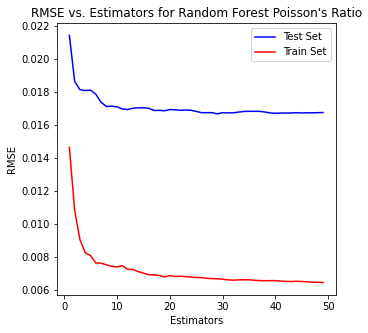

In [9]:
plot_rmse_estimators(poisson_rmse_train, poisson_rmse_test, "Poisson's Ratio")

In [33]:
#OPTIMAL NUMBER OF ESTIMATORS --> CLASS GRAPH TRAIN TEST
pred = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", "Young's modulus E (GPa)", "Shear modulus G (GPa)"], axis = 1)
X = pred.iloc[:, 0:len(compound_names)]
Y = pred.iloc[:, len(compound_names)]

X_train, X_test, y_actual_train, y_actual_test = train_test_split(X, Y, test_size=0.2, random_state=30)
regressor = RandomForestRegressor(n_estimators=15, random_state=0)
regressor.fit(X_train, y_actual_train)
y_pred_test = regressor.predict(X_test)

regressor = RandomForestRegressor(n_estimators=15, random_state=0)
regressor.fit(X_train, y_actual_train)
y_pred_train = regressor.predict(X_train)

# for i in y_actual_test:
#     print(i)
print(y_actual_test)
print(y_actual_train)

824     0.265000
436     0.215000
777     0.280000
1330    0.251067
1570    0.234375
          ...   
928     0.283000
338     0.302000
1463    0.243058
426     0.221000
208     0.234000
Name: Poisson's ratio v, Length: 321, dtype: float64
1381    0.183333
685     0.270000
501     0.271000
1200    0.184000
99      0.210000
          ...   
919     0.200000
1164    0.254000
500     0.273000
941     0.270000
421     0.277000
Name: Poisson's ratio v, Length: 1282, dtype: float64


R-Squared Test:
0.690463168204263
R-Squared Train:
0.9487460669413637


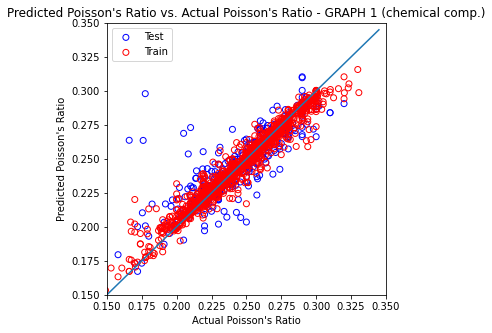

In [22]:
from sklearn.metrics import r2_score

def plot_expectedvactual(y_actual_test, y_pred_test, y_actual_train, y_pred_train, title):
    plt.scatter(y_actual_test, y_pred_test, facecolors='none', edgecolors='b', label = "Test")
    plt.scatter(y_actual_train, y_pred_train, facecolors='none', edgecolors='r', label = "Train")
    plt.xlim([0.15, 0.35])
    plt.ylim([0.15, 0.35])
    plt.title(title)
    plt.xlabel("Actual Poisson's Ratio")
    plt.ylabel("Predicted Poisson's Ratio")
    
    print("R-Squared Test:")
    print(r2_score(y_actual_test, y_pred_test))
    print("R-Squared Train:")
    print(r2_score(y_actual_train, y_pred_train))
    
    x = [0, 0.345]
    y = [0, 0.345]
    plt.plot(x, y)
    plt.legend()
    plt.show()
    
plot_expectedvactual(y_actual_test, y_pred_test, y_actual_train, y_pred_train, "Predicted Poisson's Ratio vs. Actual Poisson's Ratio - GRAPH 1 (chemical comp.)")


In [38]:
#print(y_pred_test)
#print(y_actual_test)

#print(y_pred_test)
y_actual = [i for i in y_actual_test]

a = {}
for i in range(len(y_pred_test)):
    a[i] = (abs(y_pred_test[i] - y_actual[i]), y_actual[i])
a = sorted(a.items(), key = lambda x:x[1][0], reverse = True)
print(a)


[(8, (0.12049999999999994, 0.1775)), (11, (0.09770220886666667, 0.166)), (307, (0.08760190226666661, 0.17600000000000002)), (249, (0.06380222000000005, 0.205)), (45, (0.06306666666666669, 0.21)), (163, (0.046450653400000014, 0.25)), (202, (0.04531026880000005, 0.2083333)), (189, (0.0390402866666667, 0.2459283)), (230, (0.036322940000000026, 0.21899999999999997)), (59, (0.03490666666666667, 0.1754386)), (141, (0.034376353333333304, 0.18240910000000002)), (308, (0.03406911333333337, 0.2575)), (232, (0.033667017799999976, 0.3)), (297, (0.032219713333333316, 0.2428571)), (53, (0.03175033979999997, 0.24)), (164, (0.03166666666666659, 0.27399999999999997)), (216, (0.030231586666666643, 0.26899999999999996)), (206, (0.029333333333333378, 0.32)), (153, (0.02886293333333334, 0.23600000000000002)), (95, (0.02814391999999999, 0.172)), (223, (0.028000000000000025, 0.23)), (32, (0.027528840000000027, 0.2310518)), (262, (0.02699871333333337, 0.21421679999999996)), (122, (0.026972446666666705, 0.2019

In [ ]:
#Random Forest Regressor to predict 
#https://satishgunjal.com/kfold/
kf = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(RandomForestRegressor(random_state= 42), X, Y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold are: {score}')
rmse(score.mean())

In [ ]:
#Take a break to now focus on using LASSO to extract the best features

#--MARK -- transformed_samples_by_features --> has all the data you need

In [ ]:
from sklearn.linear_model import Lasso

all_feature_names = transformed_samples_by_features.columns
all_feature_names

In [ ]:
lasso = Lasso(alpha = 0.1) #Change based on log scale, 1.0, 0.5, etc.

In [ ]:
#LASSO for Young's Modulus

X_youngs = transformed_samples_by_features.values
Y_youngs = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Young's modulus E (GPa)"].values

In [ ]:
lasso_coeff_youngs = lasso.fit(X_youngs, Y_youngs).coef_
plotting_youngs = plt.plot(range(len(all_feature_names)), lasso_coeff_youngs)
plotting_youngs = plt.xticks(range(len(all_feature_names)), all_feature_names, rotation=60)
plotting_youngs = plt.ylabel("Coefficients")
plt.show() #Do cross-validation

#Change labelling for x-axis

In [ ]:
feature_names_to_coeff = {}
for i in range(len(all_feature_names)):
    feature_names_to_coeff[all_feature_names[i]] = lasso_coeff_youngs[i]
feature_names_to_coeff #Delete all zero terms

#Rank non-zero features from high to low based on coeffs (abs val)

In [ ]:
#Different random seeds, but one train-test-split
#Each seed has its own train set (choose random seed, maybe 5, 10 or other)
#Train different lambda on train set --> you will then have a model
#You will then predict the training set using the model and the test set, calculate RMSE
#Then try different lambda

#Once you have best alpha, run again on all data 1603 x 132 without train-test, rank from highest to lowest (abs value)

#New dataset with top features, then run a new randomforest (compare)